# Preparing the dataset for hippocampus segmentation

In this section we have inspected a dataset of MRI scans and related segmentations, represented as NIFTI files. We have visualized some slices, and understood the layout of the data. We have inspected file headers to understand what how the image dimensions relate to the physical world and we have understood how to measure our volume. We have then inspected dataset for outliers, and have created a clean set that is ready for consumption by our ML algorithm. 

The dataset used for preparation can be obtained from [here](https://github.com/udacity/nd320-c3-3d-imaging-starter/tree/master/data/TrainingSet), and should be saved locally as
`/data/Training/`.

In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np 

import glob
import os

## Loading NIFTI images using NiBabel

NiBabel is a python library for working with neuro-imaging formats (including NIFTI) that we have used in some of the exercises throughout the course. Our volumes and labels are in NIFTI format, so we will use nibabel to load and inspect them.

NiBabel documentation could be found [here](https://nipy.org/nibabel/).

Our dataset sits in two directories - *images* and *labels*. Each image is represented by a single file (we are fortunate to have our data converted to NIFTI) and has a corresponding label file which is named the same as the image file.

Note that our dataset is "dirty". There are a few images and labels that are not quite right. They should be quite obvious to notice, though. The dataset contains an equal amount of "correct" volumes and corresponding labels, and you don't need to alter values of any samples in order to get the clean dataset.

In [2]:
# root_dir = os.path.join("..", "data/TrainingSet/")
root_dir = "../data/TrainingSet/"
image_path = os.path.join(root_dir, 'images/')
label_path = os.path.join(root_dir, 'labels/')

In [3]:
def load_data(dir_name):
    file_path = glob.glob(os.path.join(dir_name, '*.nii.gz'))
    print(f'Loading data from {dir_name}.')
    nii_img = []
    data = []
    for f in file_path:
        nii_img.append([f, nib.load(f)])
        data.append([f, nib.load(f).get_fdata()])
    print(f'{len(data)} images have been loaded.')
    return sorted(data), sorted(nii_img)

In [4]:
images_list, nii_img = load_data(image_path)
labels_list, nii_lbl = load_data(label_path)

Loading data from ../data/TrainingSet/images/.
263 images have been loaded.
Loading data from ../data/TrainingSet/labels/.
262 images have been loaded.


In [5]:
# Load an image and a segmentation mask into variables called image and label
img_ind = 55
image = images_list[img_ind][1]
label = labels_list[img_ind][1]
niimg = nii_img[img_ind][1]
nilbl = nii_lbl[img_ind][1]
print(f'Image path: {nii_img[img_ind][0]}')

Image path: ../data/TrainingSet/images/hippocampus_092.nii.gz


In [6]:
def view_slice(image, label):   
    fig, ax = plt.subplots(6,5,figsize=(20,25))

    for i in range(5):
        ax[0, i].imshow(image[:,:,(i*5)])
        ax[0, i].set_title(f'Slice|image {i*5}: Axial')
        ax[2, i].imshow(image[:,(i*5), :])
        ax[2, i].set_title(f'Slice|image {i*5}: Coronal')
        ax[4, i].imshow(image[(i*5),:,:,])
        ax[4, i].set_title(f'Slice|image {i*5}: Saggital')

        ax[1, i].imshow(label[:,:,(i*5)])
        ax[1, i].set_title(f'Slice|label {i*5}: Axial')
        ax[3, i].imshow(label[:,(i*5), :])
        ax[3, i].set_title(f'Slice|label {i*5}: Coronal')
        ax[5, i].imshow(label[(i*5),:,:,])
        ax[5, i].set_title(f'Slice|label {i*5}: Saggital')
    plt.show()

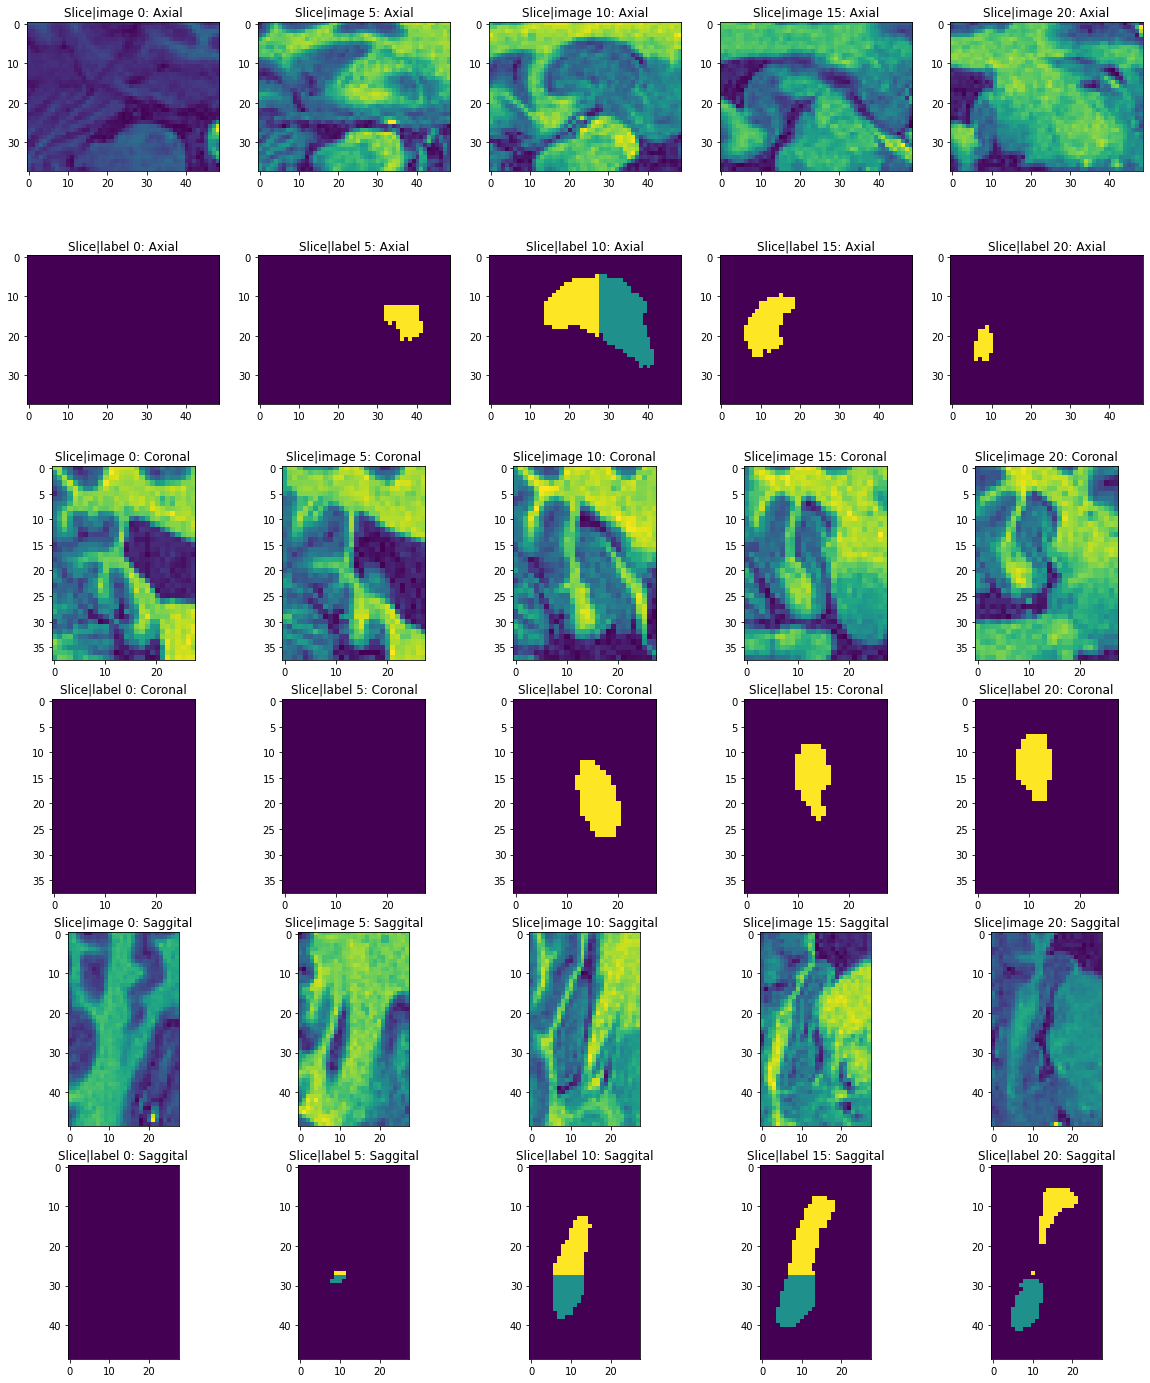

In [7]:
# Nibabel can present your image data as a Numpy array by calling the method 
# get_fdata().
# The array will contain a multi-dimensional Numpy array with numerical
# values representing voxel intensities.
# In our case, images and labels are 3-dimensional, so get_fdata will return
# a 3-dimensional array. You can verify this
# by accessing the .shape attribute. What are the dimensions of the input arrays?

# Visualize a few slices from the dataset, along with their labels.
# You can adjust plot sizes like so if you find them too small:
# plt.rcParams["figure.figsize"] = (10,10)
view_slice(image, label)


### Overlay label on MR scan

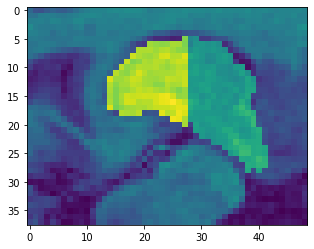

In [8]:
plt.imshow((image[:,:,10]+label[:,:,10]*500))

Load volume into 3D Slicer to validate that your visualization is correct and get a feel for the shape of structures.Try to get a visualization like the one below (hint: while Slicer documentation is not particularly great, there are plenty of YouTube videos available! Just look it up on YouTube if you are not sure how to do something)

Slicer Screenshot
![3D slicer screenshot](Slicer.png)

## Looking at single image data
In this section we will look closer at the NIFTI representation of our volumes. In order to measure the physical volume of hippocampi, we need to understand the relationship between the sizes of our voxels and the physical world.

In [9]:
# Nibabel supports many imaging formats, NIFTI being just one of them. I told you that our images 
# are in NIFTI, but you should confirm if this is indeed the format that we are dealing with
# TASK: using .header_class attribute - what is the format of our images?

print(f'Image format: {niimg.header_class}\nLabel format: {nilbl.header_class}')

Image format: <class 'nibabel.nifti1.Nifti1Header'>
Label format: <class 'nibabel.nifti1.Nifti1Header'>


Further down we will be inspecting .header attribute that provides access to NIFTI metadata. You can use this resource as a reference for various fields: https://brainder.org/2012/09/23/the-nifti-file-format/

In [10]:
# TASK: How many bits per pixel are used?
print(f"Bits per pixel/voxel \nImage: {niimg.header['bitpix']}\nLabel: {nilbl.header['bitpix']}")

Bits per pixel/voxel 
Image: 32
Label: 8


In [11]:
# TASK: What are the units of measurement?
print(f"Units of measurement \nImage: {niimg.header['xyzt_units']} \nLabel: {nilbl.header['xyzt_units']}")

Units of measurement 
Image: 10 
Label: 10


The xyzt_units equals to 2 and 8, which indicates that the spatial measurement unit is millimeter, and the temporal one is second. 

In [12]:
# TASK: Do we have a regular grid? What are grid spacings?
print(f"Regular grid spacings \nImage: {niimg.header['pixdim']} \nLabel: {nilbl.header['pixdim']}")

Regular grid spacings 
Image: [1. 1. 1. 1. 1. 0. 0. 0.] 
Label: [1. 1. 1. 1. 1. 0. 0. 0.]


This is a regular grid spacing because the pixel per voxel for the first three dimensions are equal. 

In [13]:
# TASK: What dimensions represent axial, sagittal, and coronal slices? How do you know?
niimg.header['dim']

array([ 3, 38, 49, 28,  1,  1,  1,  1], dtype=int16)

x (35), y (49), and z (37) represent sagittal, coronal, and axial slices. 
We know this because the NIFTI format follows the left-handed coordinates, 
in which +x is Right, +y is Anterior, and +z is Superior.

In [14]:
# By now you should have enough information to decide what are dimensions of a single voxel
# TASK: Compute the volume (in mm³) of a hippocampus using one of the labels you've loaded. 
# You should get a number between ~2200 and ~4500

voxel_dims = (nilbl.header["pixdim"])[1:4]
print(f'Voxel dimensions (x, y, z): {voxel_dims}') 
# Compute volume
nonzero_voxel_count = np.count_nonzero(label)
voxel_volume = np.prod(voxel_dims)
nonzero_voxel_volume = nonzero_voxel_count * voxel_volume
print(f"Volume of non-zero voxels = {nonzero_voxel_volume} mm^3")

Voxel dimensions (x, y, z): [1. 1. 1.]
Volume of non-zero voxels = 3142.0 mm^3


## Plotting some charts

In [40]:
def show_all_volume(images):
    hist_array = []
    normal_list = []
    for (f, img) in images:
        nonzero_voxel_volume = np.count_nonzero(img)
        hist_array.append(nonzero_voxel_volume)
        if (nonzero_voxel_volume > 4700) or (nonzero_voxel_volume < 2200):
            print(
                f'Outlier(s): \nPath: {f} (voxel volume: {nonzero_voxel_volume})')
        else:
            normal_list.append(nonzero_voxel_volume)

    fig, ax = plt.subplots(ncols=2, figsize=(10, 6))
    ax[0].hist(hist_array, bins=100)
    ax[0].set(title='total distribution', xlabel='voxel volumes',
              ylabel='Number of occurrences')
    ax[1].hist(normal_list, bins=100)
    ax[1].set(title='normal distribution', xlabel='voxel volumes',
              ylabel='Number of occurrences')
    print(f"Files consist of {len(hist_array)-len(normal_list)} ourliers.")


### Outlier 1: 
The voxel volume is $20702mm^3$, which is unrealistic.     
Based on the visualization, we can see that the image is not cropped for the hippocampus area, which left us with the entire brain slice. (This also explains why we get `outlier 2`.) 

Outlier(s): 
Path: ../data/TrainingSet/labels/hippocampus_281.nii.gz (voxel volume: 20702)
Files consist of 1 ourliers.


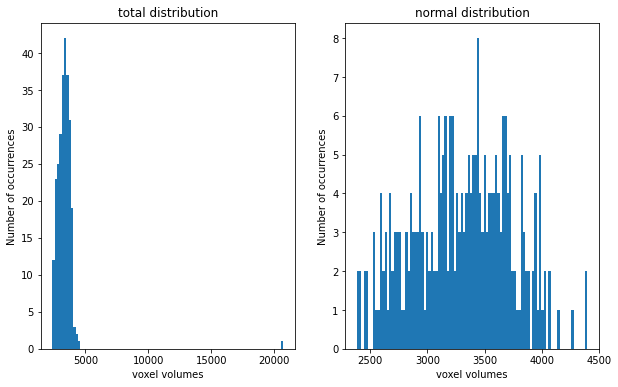

In [41]:
# TASK: Plot a histogram of all volumes that we have in our dataset and see how 
# our dataset measures against a slice of a normal population represented by the chart below.
show_all_volume(labels_list)

In [17]:
outlier_lbl = nib.load('../data/TrainingSet/labels/hippocampus_281.nii.gz')
outlier_img = nib.load('../data/TrainingSet/images/hippocampus_281.nii.gz')

In [18]:
print(f"Outlier lable dimension: {outlier_lbl.header['dim']}\nOutlier image dimension: {outlier_img.header['dim']}")

Outlier lable dimension: [  3 512 512  94   1   1   1   1]
Outlier image dimension: [  3 512 512  31   1   1   1   1]


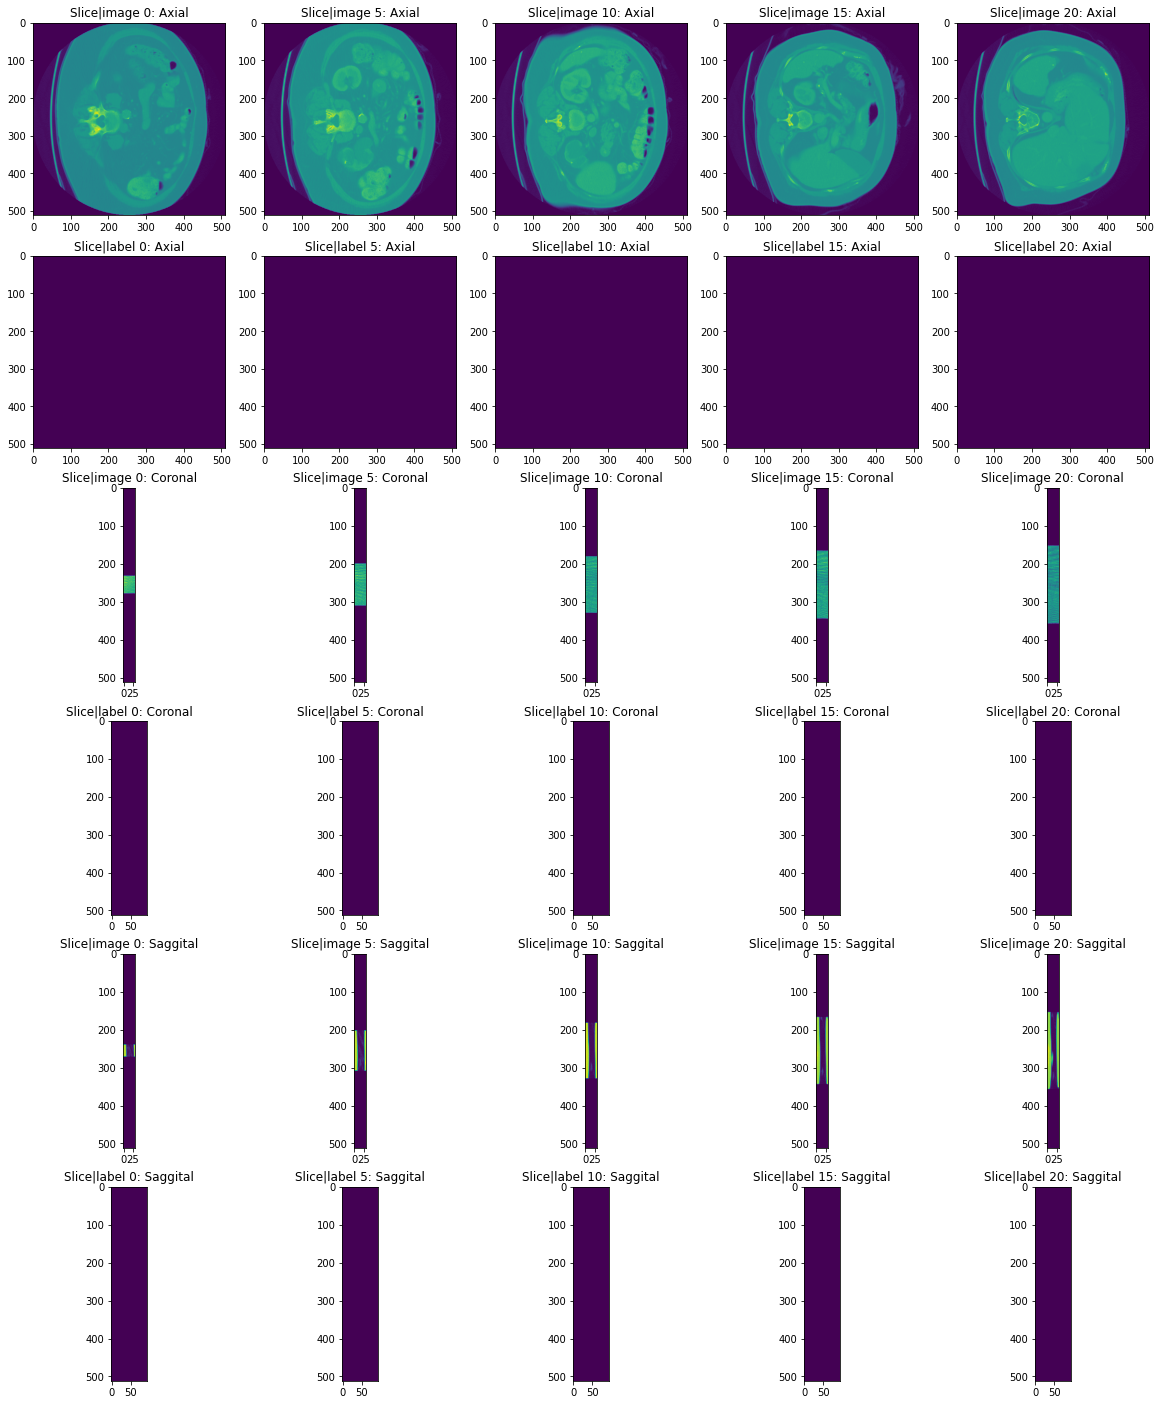

In [19]:
view_slice(outlier_img.get_fdata(), outlier_lbl.get_fdata())

### Outlier 2
After checking the dimensions of all images, we can see that apart from `hippocampus_281.nii.gz`, there is another image, `hippocampus_010.nii.gz`, in the `images` directory that has abnormal dimension information.

In [20]:
for ind, (f, lbl) in enumerate(nii_img):
    print(f, lbl.header['dim'])

../data/TrainingSet/images/hippocampus_001.nii.gz [ 3 35 51 35  1  1  1  1]
../data/TrainingSet/images/hippocampus_003.nii.gz [ 3 34 52 35  1  1  1  1]
../data/TrainingSet/images/hippocampus_004.nii.gz [ 3 36 52 38  1  1  1  1]
../data/TrainingSet/images/hippocampus_006.nii.gz [ 3 35 52 34  1  1  1  1]
../data/TrainingSet/images/hippocampus_007.nii.gz [ 3 34 47 40  1  1  1  1]
../data/TrainingSet/images/hippocampus_008.nii.gz [ 3 36 48 40  1  1  1  1]
../data/TrainingSet/images/hippocampus_010.nii.gz [  3 512 512 241   1   1   1   1]
../data/TrainingSet/images/hippocampus_011.nii.gz [ 3 36 50 31  1  1  1  1]
../data/TrainingSet/images/hippocampus_014.nii.gz [ 3 39 50 40  1  1  1  1]
../data/TrainingSet/images/hippocampus_015.nii.gz [ 3 42 51 28  1  1  1  1]
../data/TrainingSet/images/hippocampus_017.nii.gz [ 3 35 48 32  1  1  1  1]
../data/TrainingSet/images/hippocampus_019.nii.gz [ 3 36 47 41  1  1  1  1]
../data/TrainingSet/images/hippocampus_020.nii.gz [ 3 36 46 43  1  1  1  1]
../d

In [21]:
for ind, (f, lbl) in enumerate(nii_lbl):
    print(f, lbl.header['dim'])

../data/TrainingSet/labels/hippocampus_001.nii.gz [ 3 35 51 35  1  1  1  1]
../data/TrainingSet/labels/hippocampus_003.nii.gz [ 3 34 52 35  1  1  1  1]
../data/TrainingSet/labels/hippocampus_004.nii.gz [ 3 36 52 38  1  1  1  1]
../data/TrainingSet/labels/hippocampus_006.nii.gz [ 3 35 52 34  1  1  1  1]
../data/TrainingSet/labels/hippocampus_007.nii.gz [ 3 34 47 40  1  1  1  1]
../data/TrainingSet/labels/hippocampus_008.nii.gz [ 3 36 48 40  1  1  1  1]
../data/TrainingSet/labels/hippocampus_010.nii.gz [ 3 36 50 31  1  1  1  1]
../data/TrainingSet/labels/hippocampus_011.nii.gz [ 3 36 50 31  1  1  1  1]
../data/TrainingSet/labels/hippocampus_014.nii.gz [ 3 39 50 40  1  1  1  1]
../data/TrainingSet/labels/hippocampus_015.nii.gz [ 3 42 51 28  1  1  1  1]
../data/TrainingSet/labels/hippocampus_017.nii.gz [ 3 35 48 32  1  1  1  1]
../data/TrainingSet/labels/hippocampus_019.nii.gz [ 3 36 47 41  1  1  1  1]
../data/TrainingSet/labels/hippocampus_020.nii.gz [ 3 36 46 43  1  1  1  1]
../data/Trai

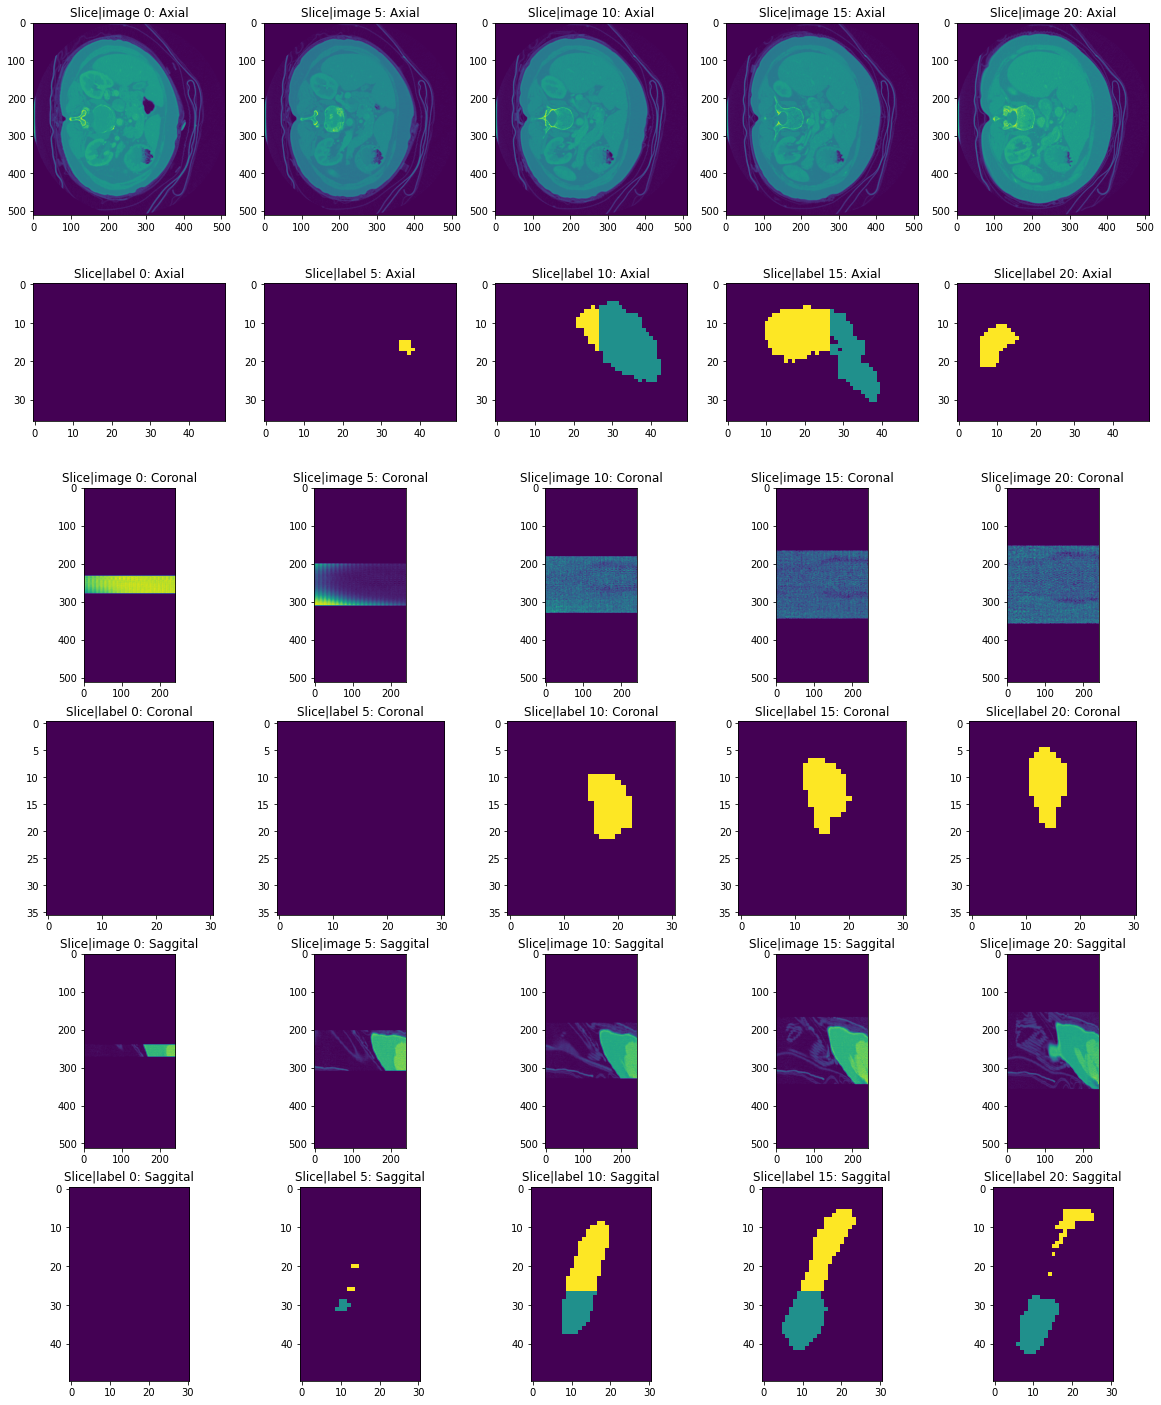

In [22]:
outlier2 = nib.load("../data/TrainingSet/images/hippocampus_010.nii.gz")
outlier2_lbl = nib.load("../data/TrainingSet/labels/hippocampus_010.nii.gz")
view_slice(outlier2.get_fdata(), outlier2_lbl.get_fdata())

### Outlier 3:
File mismatch. File `hippocampus_118.nii.gz` has no matching label. 

In [23]:
label_paths = [labels_list[i][0].split('/')[-1] for i in range(len(labels_list))]
image_paths = [images_list[i][0].split('/')[-1] for i in range(len(images_list))]
outlier3 = list(set(label_paths) - set(image_paths)) + list(set(image_paths) - set(label_paths))
print(f'Mismatch outlier: {outlier3}')

Mismatch outlier: ['hippocampus_118.nii.gz']


<img src="nomogram_fem_right.svg" width=400 align=left>

In [45]:
hi = []
lo = []
for (f, img) in labels_list:
    nonzero_voxel_volume = np.count_nonzero(img)
    if (nonzero_voxel_volume > 4500):
        hi.append(nonzero_voxel_volume)
    elif (nonzero_voxel_volume < 2900):
        lo.append(nonzero_voxel_volume)
print(f"Volumes larger than 4500mm^3: {len(hi)}\nVolumes smaller than 2900mm^3: {len(lo)}.")

Volumes larger than 4500mm^3: 1
Volumes smaller than 2900mm^3: 55.


When compared with the dataset of women's hippocampal volumes, there are 55 ourliers that are smaller than 2900mm^3. This may result from the the relatively smaller brain size or shrinked hippocampal area in the dataset. Alternatively, the women's hippocampal volumes haven't been corrected for the brain size.

In [24]:
# TASK: Copy the clean dataset to the output folder inside section1/out. Y
# ou will use it in the next Section
outliers = ['hippocampus_010.nii.gz', 'hippocampus_118.nii.gz', 'hippocampus_281.nii.gz']
clean_img_fname = [a for a in image_paths if a not in outliers]
clean_lbl_fname = [a for a in label_paths if a not in outliers]

In [25]:
src_img = image_path
src_lbl = label_path
dst_img = './out/images'
dst_lbl = './out/labels'

In [26]:
import shutil

In [28]:
def copy_files(src, dst, fname):
    if(not(os.path.exists(dst))):
        print(f'Create parent directory {dst}...')
        os.mkdir(dst)
    print(f"Copying files from {src} to {dst}...")
    for f in fname:
        src_path = os.path.join(src, f)
        shutil.copy(src_path, dst)
    print(f"Finish copying {len(fname)} files.")

In [ ]:
copy_files(src_img, dst_img, clean_img_fname)

In [ ]:
copy_files(src_lbl, dst_lbl, clean_lbl_fname)